# Search through videos using fast.ai

This notebook will walk you through a simple example that trains a model to determine if there's a bicycle in an image and then use that to find bicycles in a video.

This work is based on the early lessons in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course.

## Using this notebook

Essentially you need a computer that's running a GPU running fast.ai. There are a few ways to do this without owning a computer with a GPU (I certainly don't). There are [lots of options](https://course.fast.ai/index.html). I like to use use [the Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is probably the most complicated. In most of these cases, you'll just clone [the workshop repository](https://github.com/Quartz/aistudio-workshops) and get the notebook running.

I'm also tailoring this notebook for use with [Google Colaboratory](https://colab.research.google.com), which as of this writing is the fastest, cheapest (free) way to get going.


### If you're using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes).

There are great steps on the fast.ai site for [getting started with fast.ai an Google Colab](https://course.fast.ai/start_colab.html). 

Those instructions will show you how to save your own copy of this _notebook_ to Google Drive.

They also tell you how to save a copy of your _data_ to Google Drive (Step 4), which is unneccesary for this workshop. 

In [ ]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

### If you are _not_ using Google Colaboratory ...

Run the cell below.

In [34]:
## ALL OTHER USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Everybody do this ...

In [35]:
## AND EVERYBODY RUNS THIS CELL

!sudo apt --yes install ffmpeg

import glob
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image as Show
from IPython.display import Video


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:2.8.15-0ubuntu0.16.04.1).
The following packages were automatically installed and are no longer required:
  libaio1 librados2 librbd1 librdmacm1 linux-aws-headers-4.4.0-1077
  linux-aws-headers-4.4.0-1079 linux-aws-headers-4.4.0-1083
  linux-aws-headers-4.4.0-1084 linux-aws-headers-4.4.0-1085
  linux-aws-headers-4.4.0-1087 linux-headers-4.4.0-1077-aws
  linux-headers-4.4.0-1079-aws linux-headers-4.4.0-1083-aws
  linux-headers-4.4.0-1084-aws linux-headers-4.4.0-1085-aws
  linux-headers-4.4.0-1087-aws linux-image-4.4.0-1077-aws
  linux-image-4.4.0-1079-aws linux-image-4.4.0-1083-aws
  linux-image-4.4.0-1084-aws linux-image-4.4.0-1085-aws
  linux-image-4.4.0-1087-aws linux-modules-4.4.0-1077-aws
  linux-modules-4.4.0-1079-aws linux-modules-4.4.0-1083-aws
  linux-modules-4.4.0-1084-aws linux-modules-4.4.0-1085-aws
  linux-modules-4.4.0-1087-aws
Use 'sudo a

## The Plan

The goal is to see if we can spot something specific in a video. This would be useful especially if you had hours of video you didn't have time to watch.

In our case, we'll try to spot bicycles in this video:


Our plan will be:

- Download a computer-vision model pre-trained on 14 million images
- Further train that model on images containing "yes bikes" and "no bikes"
- Chop up our video into frames
- Use the model to detect bikes in frames

## The Data

Let's get the video and the "yes bikes" and "no bikes" images, which are in the folders `1` and `0` respectively.

In [36]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
!unzip bikes_data.zip > /dev/null
print('Done!')

--2019-08-15 18:37:22--  https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
Resolving qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)... 52.216.17.64
Connecting to qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)|52.216.17.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326414092 (311M) [application/zip]
Saving to: ‘bikes_data.zip’

bikes_data.zip      100%[===================>] 311.29M  98.3MB/s    in 3.2s    

2019-08-15 18:37:25 (98.3 MB/s) - ‘bikes_data.zip’ saved [326414092/326414092]

Done!


Now you have a subdirectory called `bikes_data` which contains two folders (`0` and `1`) and the movie.

In [37]:
%ls bikes_data

images/  intersection_movie.mov  never_seen_image.jpg


In [38]:
%ls bikes_data/images

0/  1/


In [39]:
%ls bikes_data/images/1

bikevid010.jpg  IMG_1482.JPG  IMG_1502.JPG  IMG_1524.JPG  IMG_1675.JPG
bikevid042.jpg  IMG_1483.JPG  IMG_1504.JPG  IMG_1525.JPG  IMG_1678.JPG
bikevid062.jpg  IMG_1486.JPG  IMG_1505.JPG  IMG_1527.JPG  IMG_1679.JPG
bikevid080.jpg  IMG_1490.JPG  IMG_1506.JPG  IMG_1528.JPG  IMG_1680.JPG
bikevid104.jpg  IMG_1491.JPG  IMG_1508.JPG  IMG_1533.JPG  IMG_1682.JPG
bikevid118.jpg  IMG_1492.JPG  IMG_1510.JPG  IMG_1541.JPG  IMG_1687.JPG
bikevid120.jpg  IMG_1494.JPG  IMG_1514.JPG  IMG_1547.JPG  IMG_1696.JPG
bikevid124.jpg  IMG_1497.JPG  IMG_1516.JPG  IMG_1548.JPG  IMG_1700 2.JPG
IMG_1479.JPG    IMG_1498.JPG  IMG_1518.JPG  IMG_1549.JPG  IMG_1702.JPG
IMG_1480.JPG    IMG_1500.JPG  IMG_1519.JPG  IMG_1553.JPG  IMG_1703.JPG
IMG_1481.JPG    IMG_1501.JPG  IMG_1520.JPG  IMG_1600.JPG


Let's take a looks at one ...

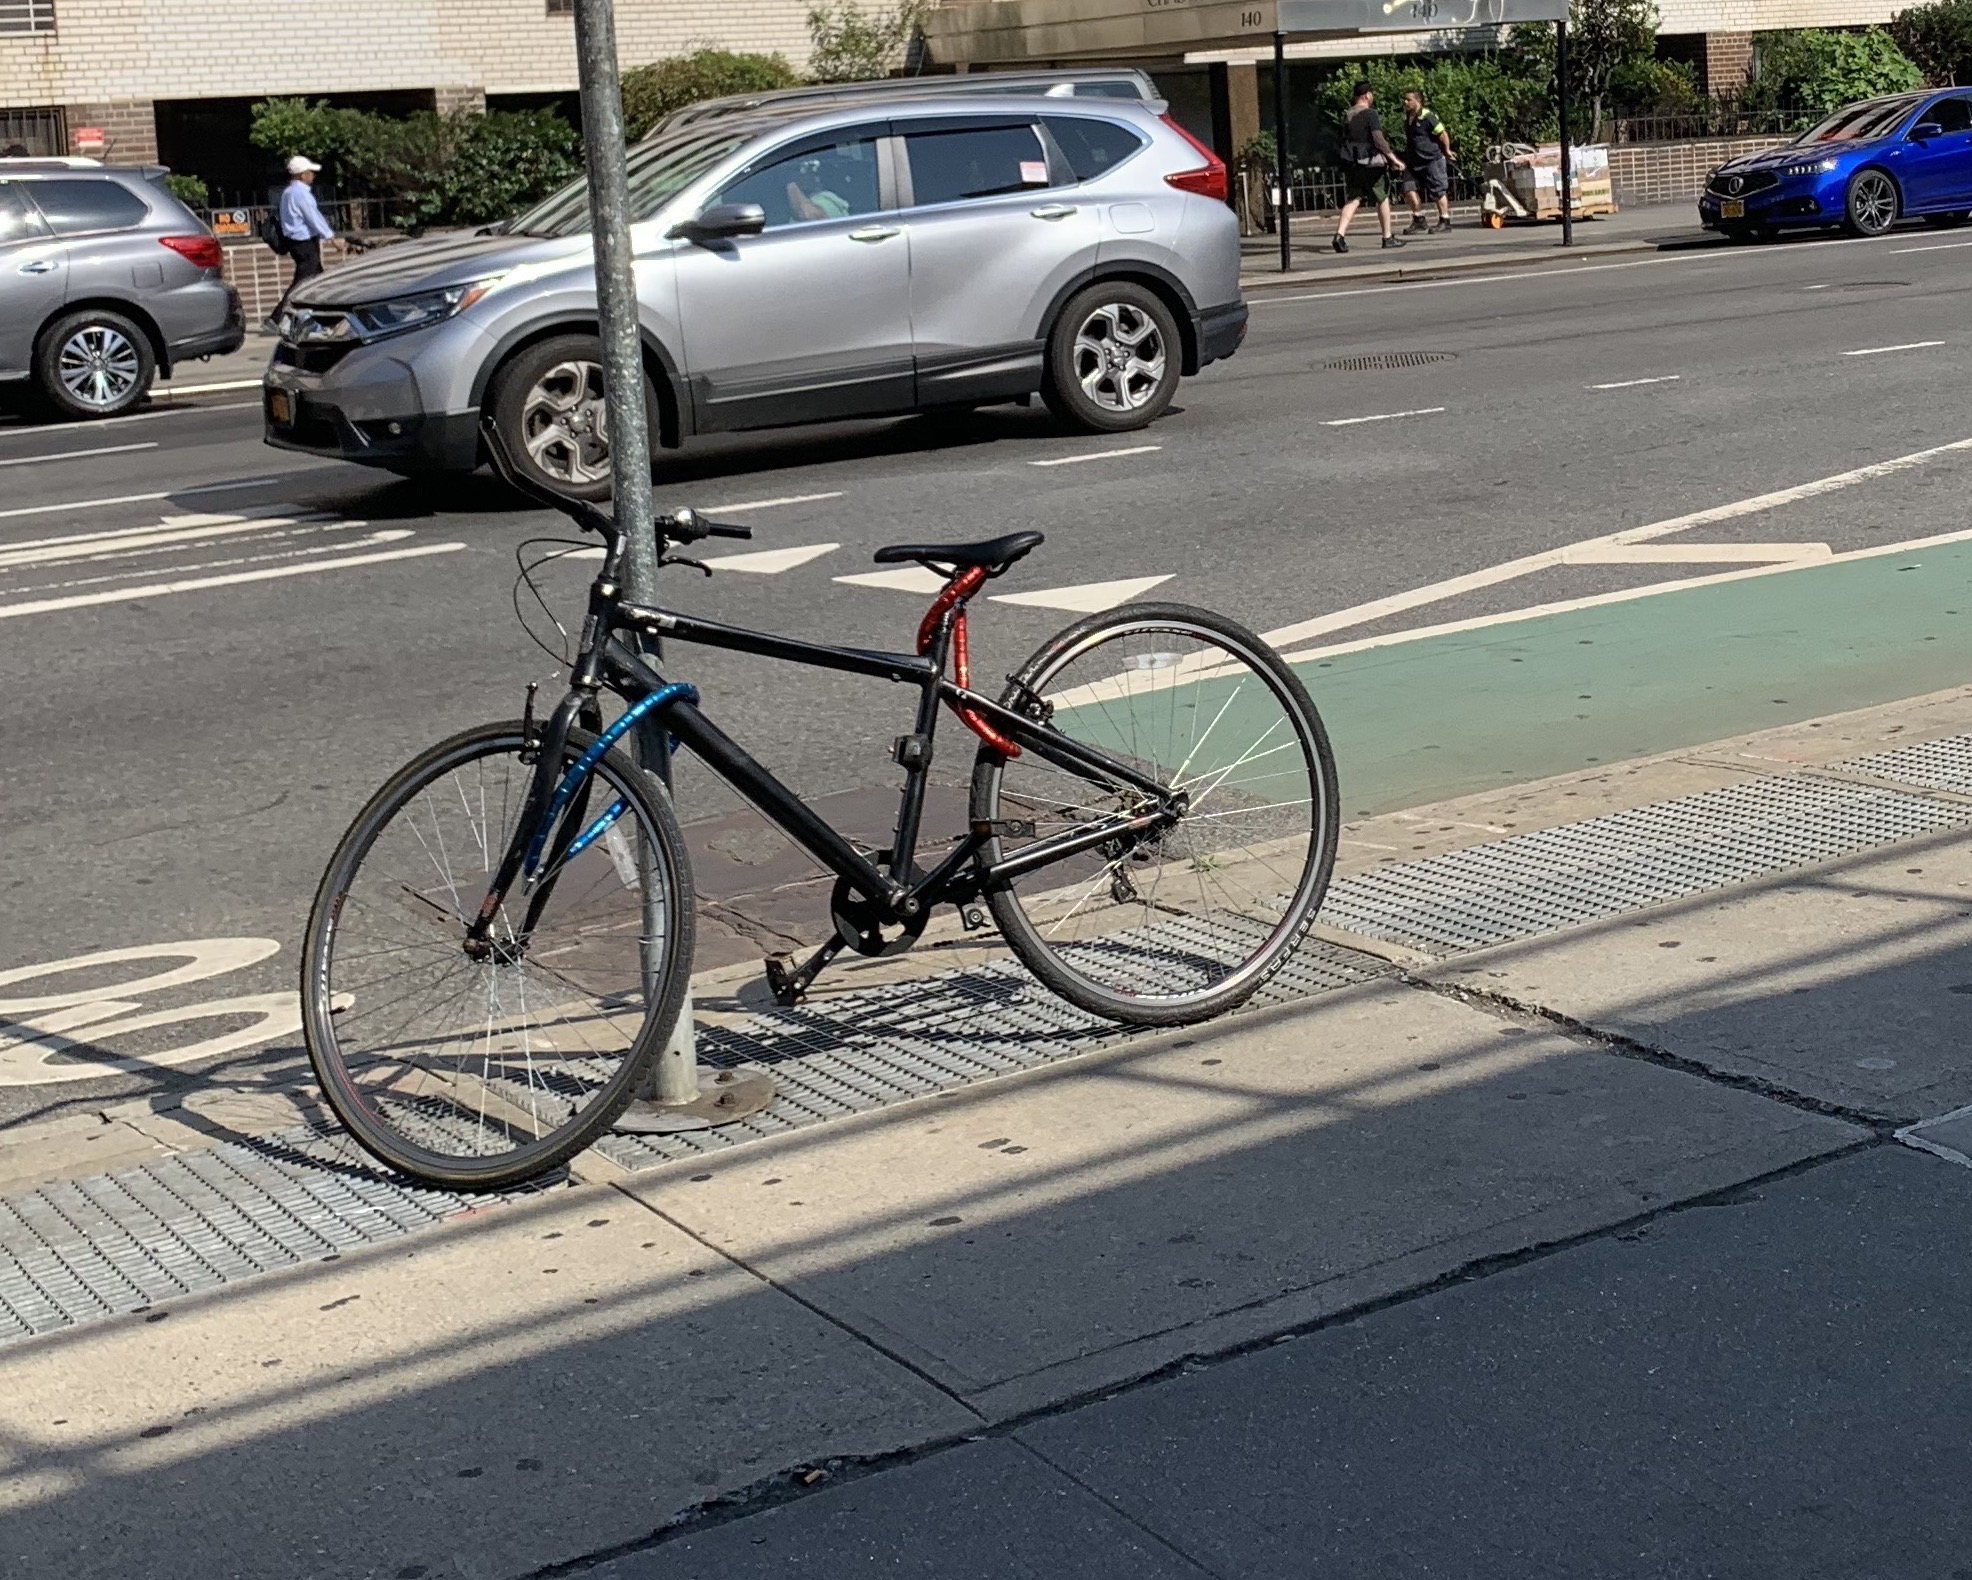

In [40]:
Show(filename='bikes_data/images/1/IMG_1494.JPG')

In [41]:
Video('bikes_data/intersection_movie.mov')

Now we need to load in data in a format that's ready for the training code. We do that with fast.ai's data block.

In [42]:
data_path = Path('./bikes_data/images') ## The path for our data
save_path = Path('./bikes_data/') ## The path where we save things (it's the same for now)

np.random.seed(12)

data = (ImageList.from_folder(data_path)  #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()  #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()         #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(), size=(224,224))  #Data transforms applied, size of images shrink to 224
        .databunch(bs=48))

In [43]:
data_path.ls()

[PosixPath('bikes_data/images/1'), PosixPath('bikes_data/images/0')]

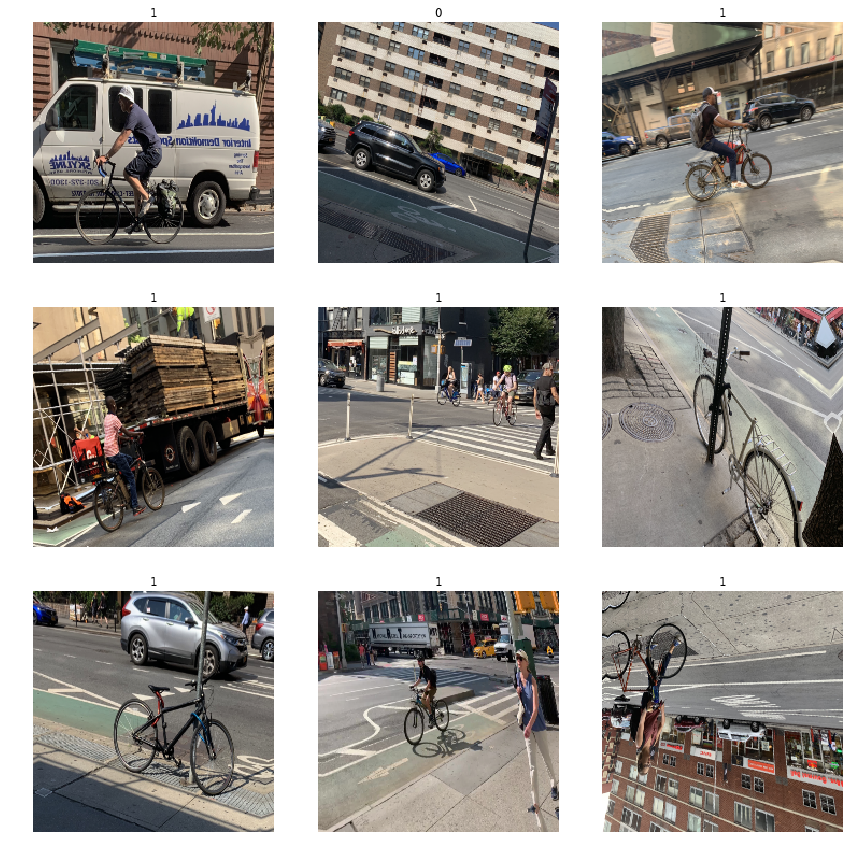

In [44]:
data.show_batch(rows=3)

In [45]:
# Let's be sure to check our classes
print(data.classes)

['0', '1']


## Training

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Most people don't! For a deeper dive, check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: 0 and 1

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning."

First we load our data and `model.resnet34` together into a training model known as a "learner."

In [46]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We will train for 6 epochs (6 cycles through all our data).

In [47]:
learn.fit_one_cycle(6)

#### How are we doing?
So far, we have an error rate of 5% ... which isn't bad!

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not.

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

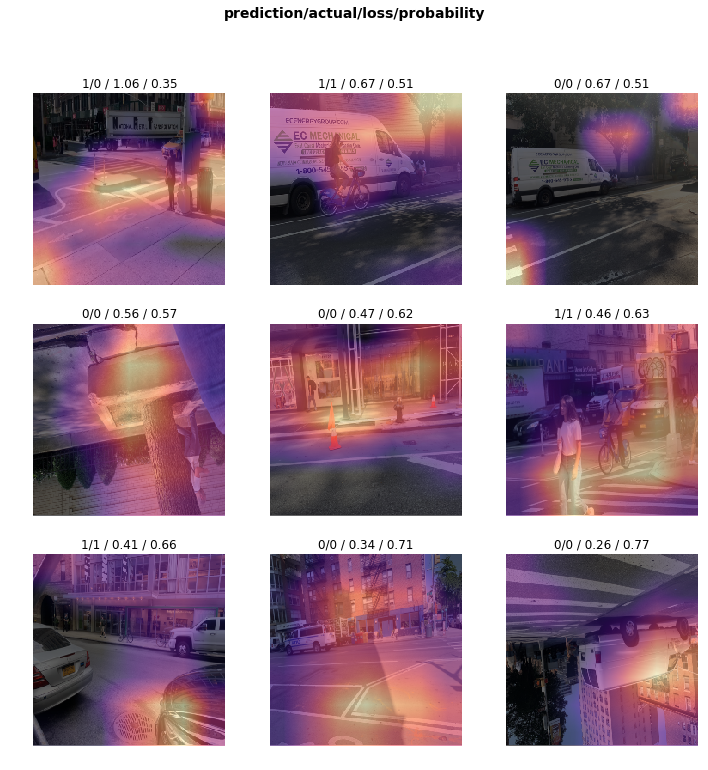

In [49]:
interp.plot_top_losses(9, heatmap=True)

We can also see the situations in which it was most confused:

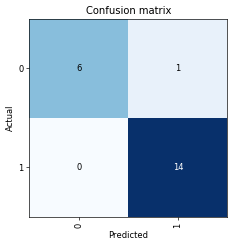

In [50]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's save what we have in case we mess it up later!

In [51]:
learn.save('bikes-1')

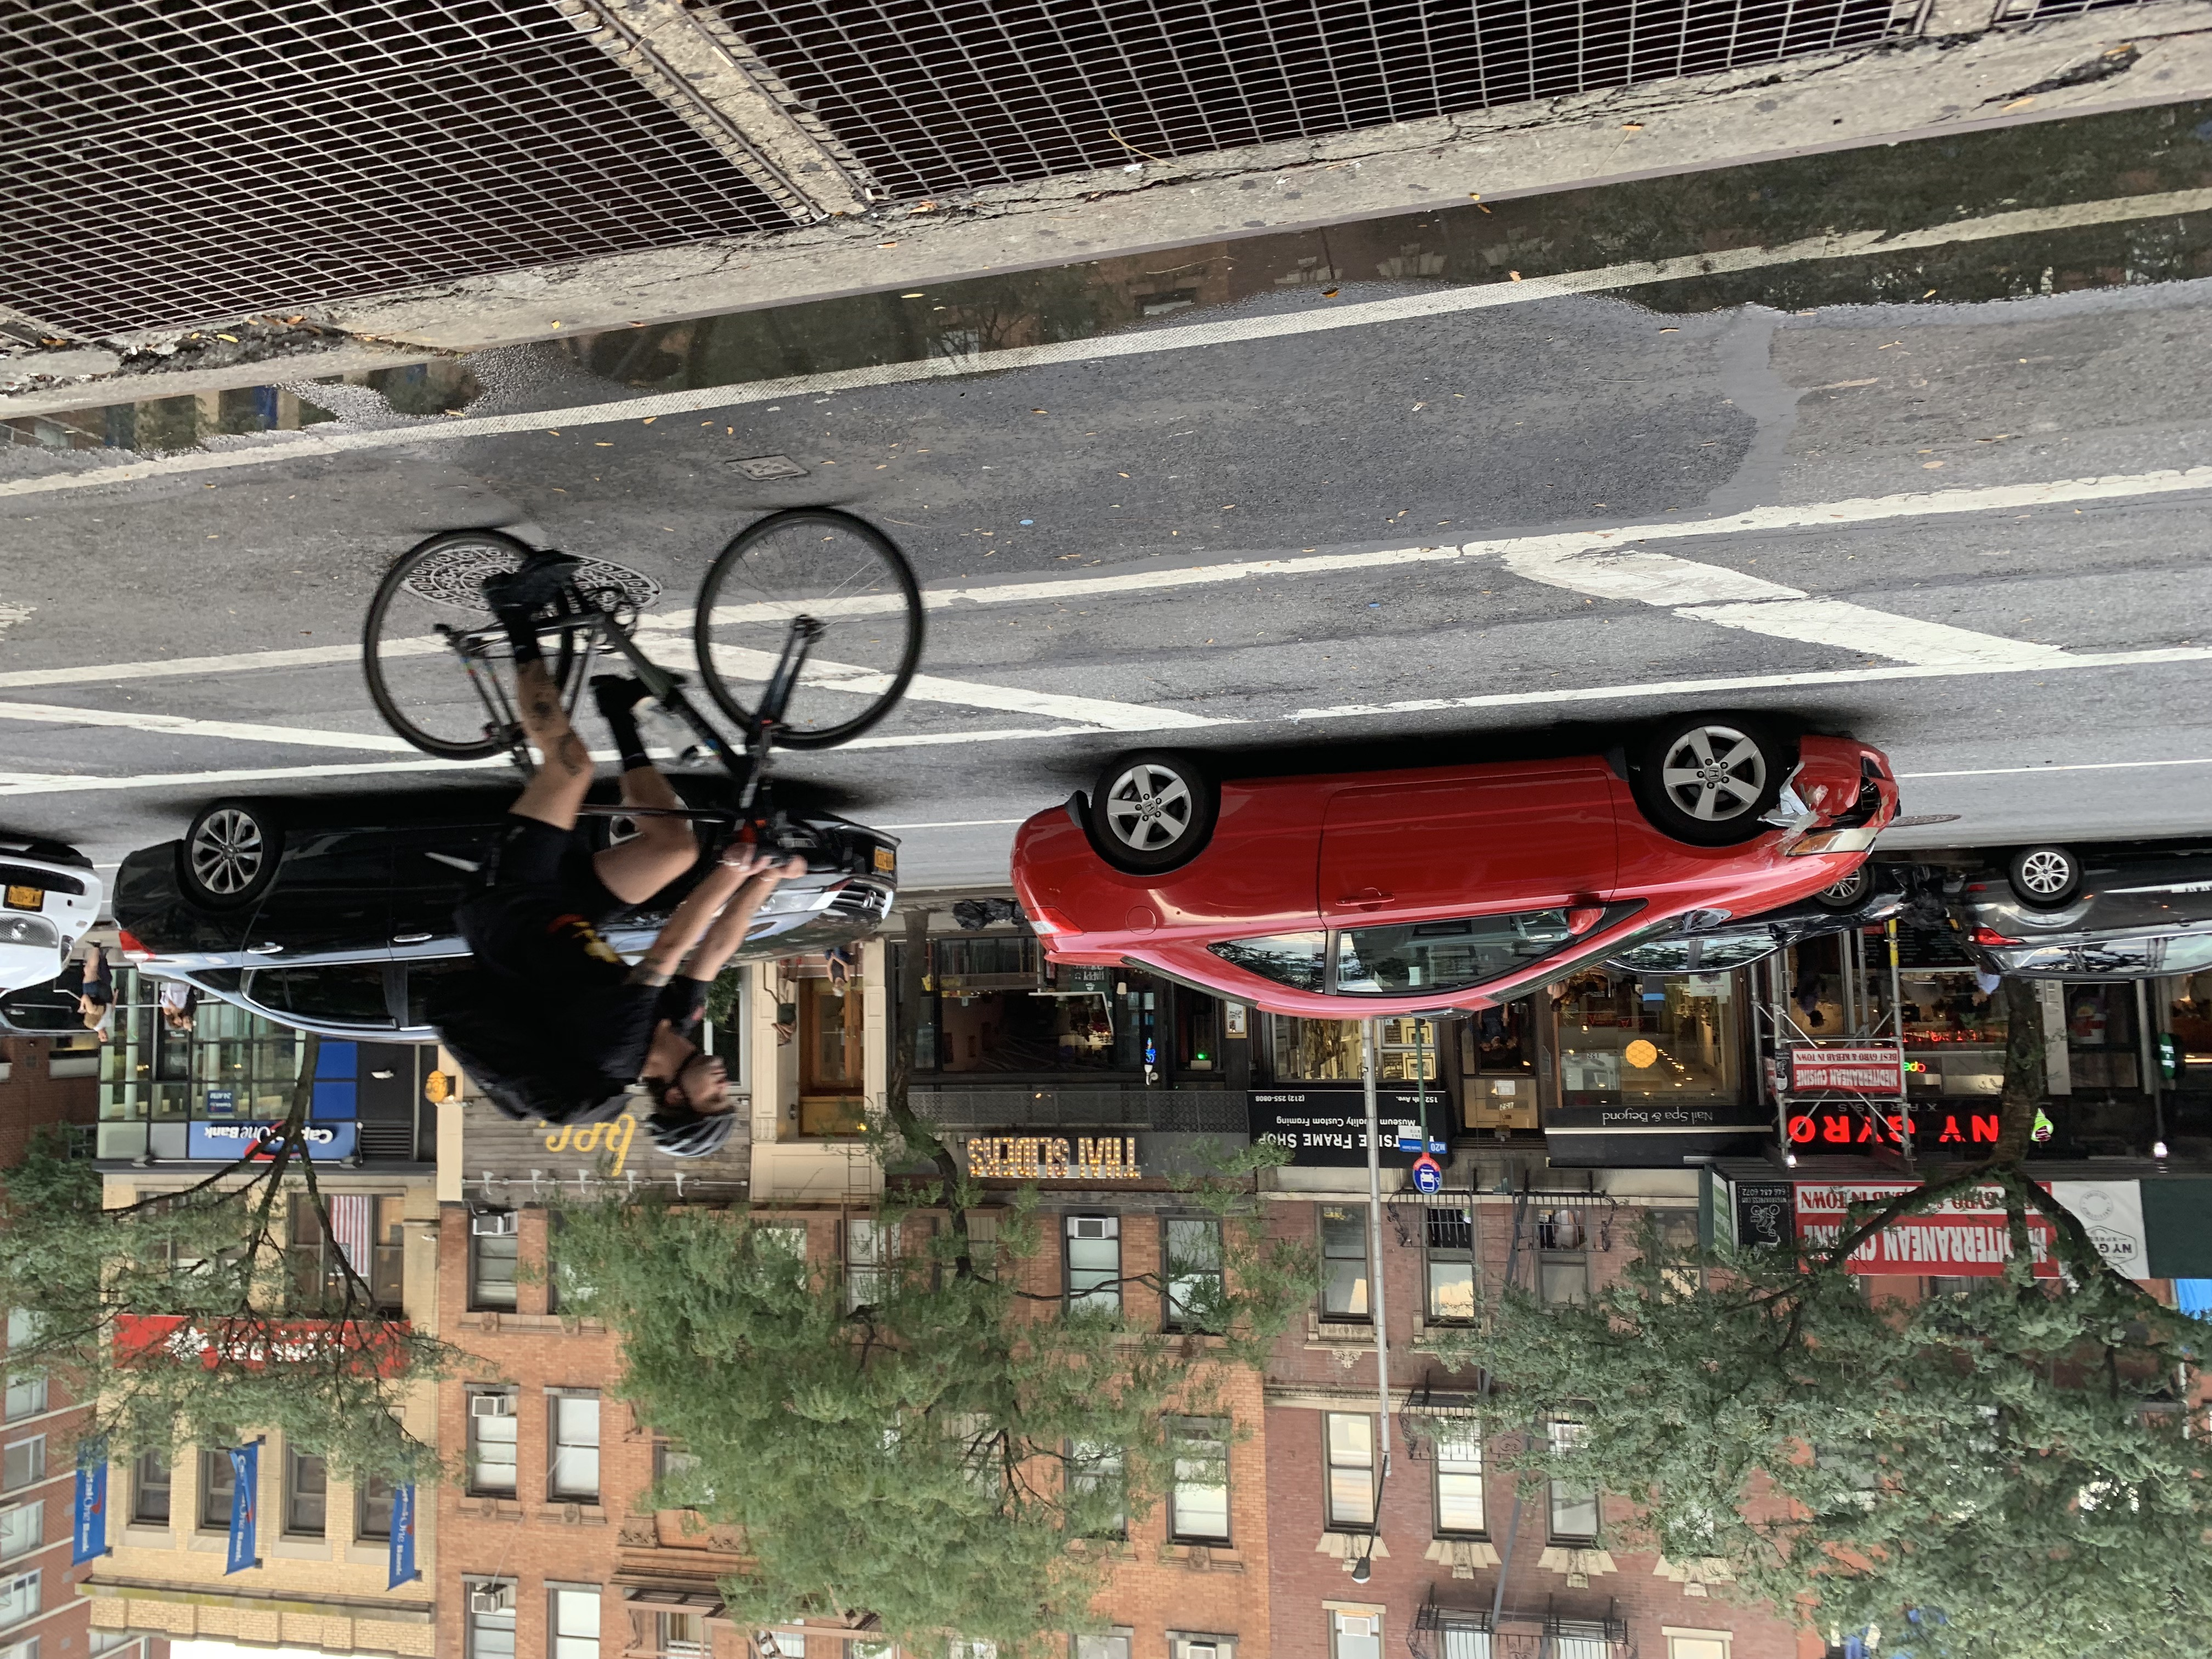

In [52]:
Show('bikes_data/never_seen_image.jpg')

In [53]:
img = open_image('bikes_data/never_seen_image.jpg')

In [54]:
learn.predict(img)

(Category 1, tensor(1), tensor([0.2580, 0.7420]))

In [60]:
pred_class,pred_idx,outputs = learn.predict(img)

In [61]:
pred_class

Category 1

In [63]:
int(pred_class)

1

In [67]:
outputs

tensor([0.2580, 0.7420])

In [66]:
outputs[1]

tensor(0.7420)


We're also going to _export_ the entire package as a "pickle" file called `export.pkl`

**Warning for Google Colab users!** Later, when you've done more fine tuning and want to save what you've done, you need to give permission for this notebook to write files to your Google Drive. In that case, you'll want to run the next cell and follow the permission-granting steps. For now, you can skip this.

In [ ]:
## THIS CELL WILL ALLOW GOOGLE COLAB USERS SAVE MODELS TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
save_path = Path(root_dir + 'ai-bikes/')
save_path.mkdir(parents=True, exist_ok=True)

In [56]:
learn.export("export.pkl")

## Search our video

Now we'll apply our model to our video! First we need to turn the video into a bunch of images using `ffmpeg`, which we loaded at the beginning of this notebook.

In [57]:
!ffmpeg -i bikes_data/intersection_movie.mov -vf fps=1 -vsync 0 myframe%04d.jpg

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [58]:
%ls

bikes_data/      myframe0011.jpg  myframe0023.jpg  myframe0035.jpg
bikes_data.zip   myframe0012.jpg  myframe0024.jpg  myframe0036.jpg
myframe0001.jpg  myframe0013.jpg  myframe0025.jpg  myframe0037.jpg
myframe0002.jpg  myframe0014.jpg  myframe0026.jpg  myframe0038.jpg
myframe0003.jpg  myframe0015.jpg  myframe0027.jpg  myframe0039.jpg
myframe0004.jpg  myframe0016.jpg  myframe0028.jpg  myframe0040.jpg
myframe0005.jpg  myframe0017.jpg  myframe0029.jpg  myframe0041.jpg
myframe0006.jpg  myframe0018.jpg  myframe0030.jpg  myframe0042.jpg
myframe0007.jpg  myframe0019.jpg  myframe0031.jpg  myframe0043.jpg
myframe0008.jpg  myframe0020.jpg  myframe0032.jpg  video-search.ipynb
myframe0009.jpg  myframe0021.jpg  myframe0033.jpg
myframe0010.jpg  myframe0022.jpg  myframe0034.jpg


In [59]:
glob.glob('myframe*.*')

['myframe0006.jpg',
 'myframe0023.jpg',
 'myframe0004.jpg',
 'myframe0013.jpg',
 'myframe0007.jpg',
 'myframe0016.jpg',
 'myframe0003.jpg',
 'myframe0001.jpg',
 'myframe0041.jpg',
 'myframe0043.jpg',
 'myframe0032.jpg',
 'myframe0039.jpg',
 'myframe0021.jpg',
 'myframe0009.jpg',
 'myframe0017.jpg',
 'myframe0031.jpg',
 'myframe0027.jpg',
 'myframe0014.jpg',
 'myframe0005.jpg',
 'myframe0025.jpg',
 'myframe0008.jpg',
 'myframe0002.jpg',
 'myframe0035.jpg',
 'myframe0036.jpg',
 'myframe0019.jpg',
 'myframe0030.jpg',
 'myframe0012.jpg',
 'myframe0029.jpg',
 'myframe0038.jpg',
 'myframe0018.jpg',
 'myframe0015.jpg',
 'myframe0037.jpg',
 'myframe0026.jpg',
 'myframe0034.jpg',
 'myframe0042.jpg',
 'myframe0020.jpg',
 'myframe0024.jpg',
 'myframe0033.jpg',
 'myframe0040.jpg',
 'myframe0010.jpg',
 'myframe0011.jpg',
 'myframe0022.jpg',
 'myframe0028.jpg']

In [ ]:
# learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [73]:
file_list = sorted(glob.glob('myframe*.*'))

for file in file_list:
    image = open_image(file)
    pred_class,pred_idx,outputs = learn.predict(image)
        
    if int(pred_class) == 1 and outputs[1] > 0.85:
        print(f'Bike detected in {file} with confidence {outputs[1]}')
    

Bike detected in myframe0022.jpg with confidence 0.9741913676261902
Bike detected in myframe0023.jpg with confidence 0.9968580007553101
Bike detected in myframe0024.jpg with confidence 0.9992666840553284
Bike detected in myframe0025.jpg with confidence 0.8549523949623108
Bike detected in myframe0026.jpg with confidence 0.9179253578186035
Bike detected in myframe0031.jpg with confidence 0.9471147656440735
Bike detected in myframe0037.jpg with confidence 0.8948110342025757


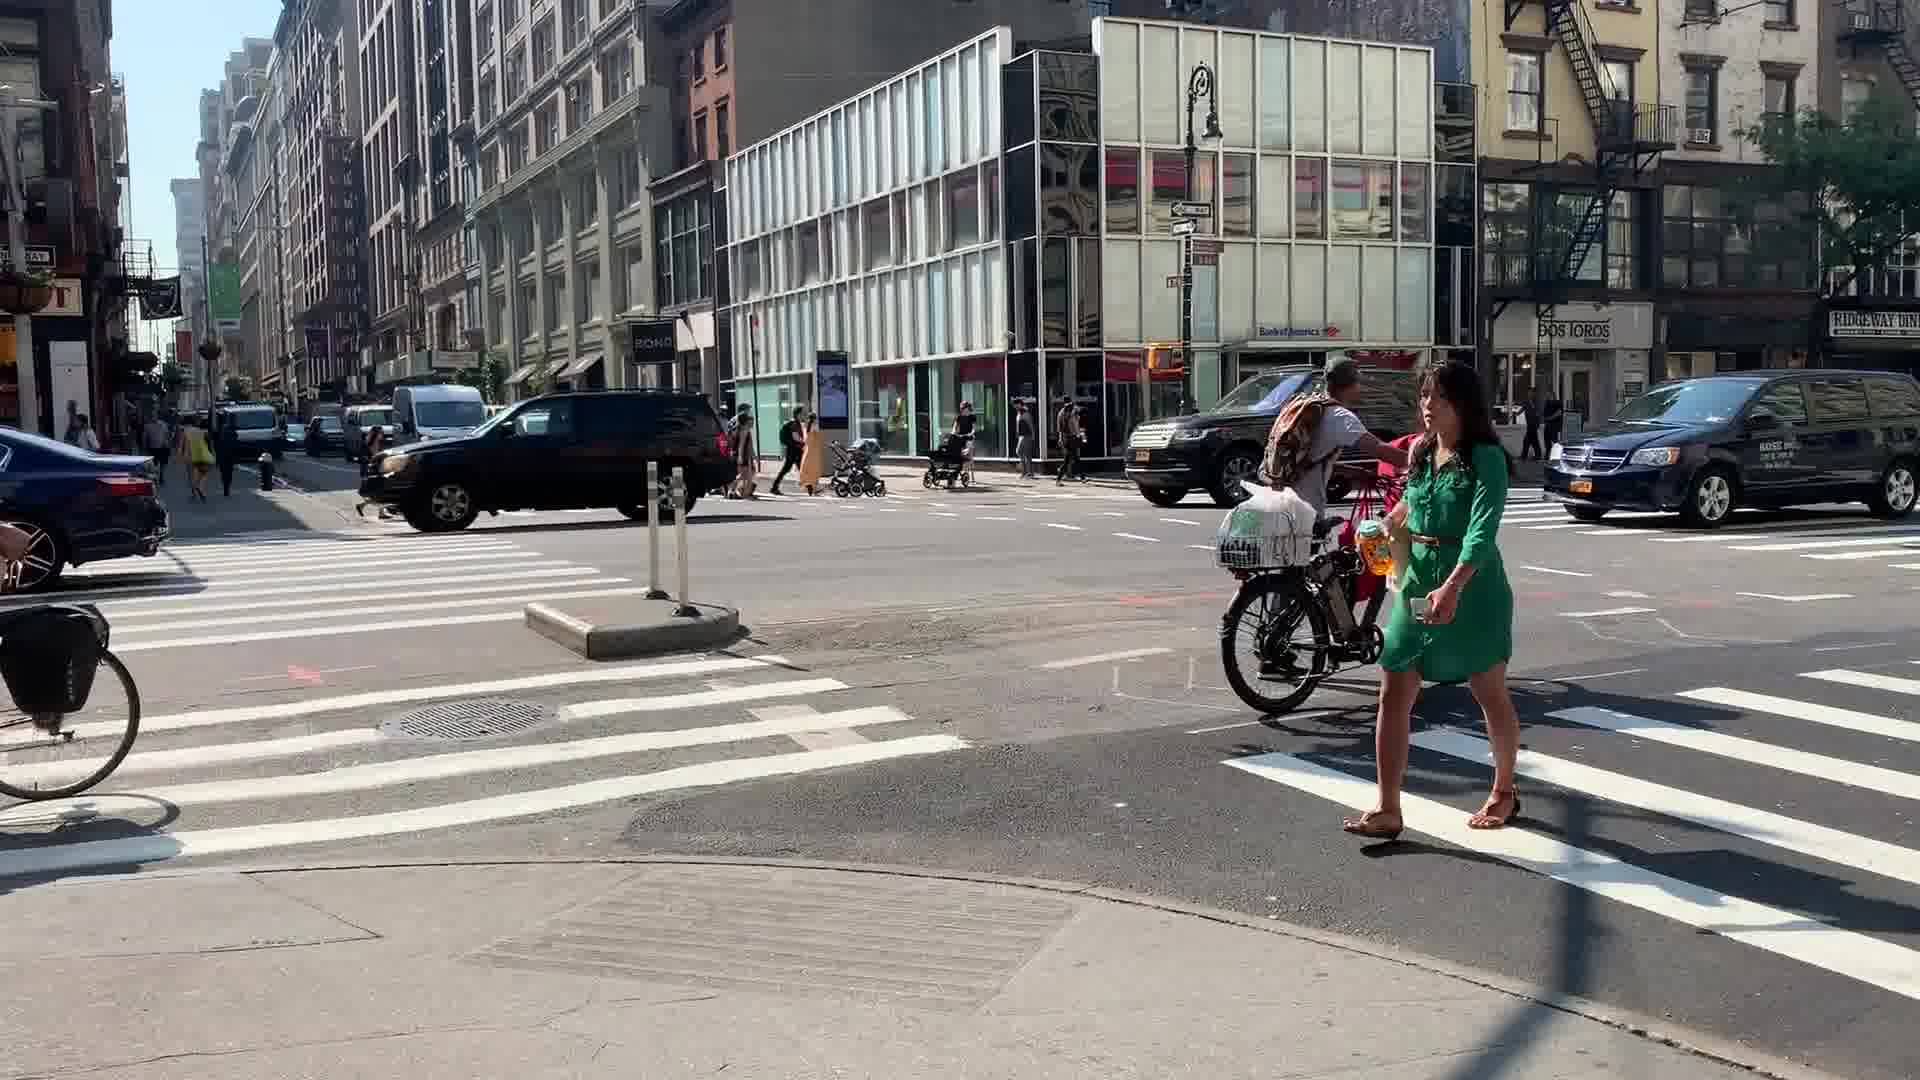

In [75]:
Show(filename='myframe0025.jpg')